In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset, DatasetDict

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = pd.read_csv('../input/edos-1m/EDOS 1M.csv')
X,y = dataset["uttr"], dataset["eb+_emot"]

print(X.head(5))
print(type(X), end="\n\n")
print(y.head(5))
print(type(y), end="\n\n")

classes = y.unique()
classes

0    You moron ! What fool washes diapers by the we...
1                                   You useless fool !
2                                 How dare you sleep !
3                        Up ! Go and clean the house .
4                                  Clean the kitchen .
Name: uttr, dtype: object
<class 'pandas.core.series.Series'>

0       angry
1     furious
2     furious
3    prepared
4    prepared
Name: eb+_emot, dtype: object
<class 'pandas.core.series.Series'>



array(['angry', 'furious', 'prepared', 'acknowledging', 'trusting',
       'confident', 'hopeful', 'caring', 'sentimental', 'anticipating',
       'wishing', 'surprised', 'ashamed', 'questioning', 'sad',
       'nostalgic', 'devastated', 'terrified', 'embarrassed', 'lonely',
       'encouraging', 'suggesting', 'content', 'afraid', 'impressed',
       'agreeing', 'apprehensive', 'proud', 'annoyed', 'anxious',
       'grateful', 'excited', 'neutral', 'faithful', 'guilty',
       'consoling', 'disgusted', 'disappointed', 'jealous', 'joyful',
       'sympathizing'], dtype=object)

# Preparation

In [3]:
# fix OCR errors
correct = False

if correct:
    list_X = X.to_list()
    for i in tqdm(range(len(list_X))):
        uttr = list_X[i]
        words = uttr.split(" ")
        filtered_words = []
        for word in words:
            #filtering away all numbers -> not good
            if all(char.isalpha() for char in word):
                filtered_words.append(word)
        list_X[i] = ' '.join(filtered_words)
    X = pd.Series(list_X)

X.head(5)

0    You moron ! What fool washes diapers by the we...
1                                   You useless fool !
2                                 How dare you sleep !
3                        Up ! Go and clean the house .
4                                  Clean the kitchen .
Name: uttr, dtype: object

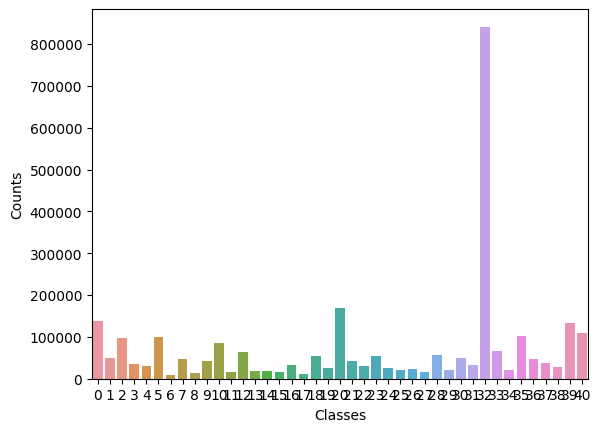

In [4]:
# plot classes distribution
counts = pd.get_dummies(y).sum()

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = [i for i in range(len(classes))], y = counts)
plt.show()

In [5]:
# train, validation and test split
no_test_X, test_X, no_test_y, test_y = train_test_split(X, y, test_size=0.15, stratify=y)
train_X, valid_X, train_y, valid_y = train_test_split(no_test_X, no_test_y, test_size=0.15, stratify=no_test_y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))
print("test size: ", len(test_X))

train size:  2044260
validation size:  360752
test size:  424414


In [6]:
# vectorize the text using word count
vectorizer = CountVectorizer(min_df=7, stop_words='english')
vectorizer.fit(train_X)
print("Vocabulary length: " + str(len(vectorizer.get_feature_names_out())))
print("First words: " + str(vectorizer.get_feature_names_out()[:200]))

train_X_vector = vectorizer.transform(train_X)
valid_X_vector = vectorizer.transform(valid_X)
test_X_vector = vectorizer.transform(test_X)

Vocabulary length: 39821
First words: ['00' '000' '007' '00am' '00pm' '01' '02' '03' '04' '05' '06' '0600' '07'
 '0700' '08' '0800' '09' '0900' '0f' '0h' '0k' '0n' '0ne' '0r' '0th' '0ur'
 '10' '100' '1000' '10000' '100s' '100th' '101' '102' '103' '104' '104th'
 '105' '106' '107' '108' '109' '10am' '10k' '10pm' '10s' '10th' '11' '110'
 '1100' '111' '112' '113' '114' '115' '116' '117' '118' '119' '11th' '12'
 '120' '1200' '123' '124' '125' '127' '128' '12th' '13' '130' '1300' '132'
 '134' '135' '13th' '14' '140' '1400' '141' '142' '143' '145' '147' '148'
 '14th' '15' '150' '1500' '155' '156' '15th' '16' '160' '1600' '165'
 '16th' '17' '170' '1700' '175' '17th' '18' '180' '1800' '1800s' '185'
 '1860' '1862' '1864' '1890' '18th' '19' '190' '1900' '1901' '1906' '1910'
 '1911' '1912' '1914' '1916' '1917' '1918' '1920' '1924' '1926' '1928'
 '1929' '1930' '1930s' '1931' '1932' '1933' '1934' '1935' '1936' '1937'
 '1938' '1939' '1940' '1941' '1942' '1943' '1944' '1945' '1946' '1947'
 '1948' '194

# Single utterance classification - Baseline model

In [7]:
# going for SVMs since they're usually reliable with high dimensional data
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, max_iter=5, tol=None)
model.fit(train_X_vector, train_y)

SGDClassifier(alpha=1e-05, max_iter=5, tol=None)

In [8]:
# validate the model
pred_y = model.predict(valid_X_vector)

print('Results for the basic SVM classifier:')
print(classification_report(valid_y, pred_y, target_names=classes))

Results for the basic SVM classifier:
               precision    recall  f1-score   support

        angry       0.48      0.27      0.35     17616
      furious       0.58      0.58      0.58      6284
     prepared       0.36      0.17      0.23     12312
acknowledging       0.43      0.17      0.24      4453
     trusting       0.33      0.15      0.21      3834
    confident       0.46      0.48      0.47     12805
      hopeful       0.46      0.28      0.35      1094
       caring       0.30      0.11      0.16      5958
  sentimental       0.43      0.18      0.26      1887
 anticipating       0.27      0.12      0.17      5458
      wishing       0.33      0.22      0.26     10827
    surprised       0.21      0.14      0.16      2200
      ashamed       0.51      0.36      0.42      8233
  questioning       0.34      0.17      0.22      2236
          sad       0.37      0.27      0.31      2333
    nostalgic       0.60      0.40      0.48      1921
   devastated       0.65  

# Single utterance classification - Transformer-based model

In [9]:
# model metadata
model_name = "bert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

cuda


In [10]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# load the model
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes))
bert = bert.to(device)
bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
# disable weights in encoder
only_fine_tuning = True

if only_fine_tuning:
    for param in bert.bert.parameters():
        param.requires_grad = False

for param in bert.parameters():
    print(param.size(), param.requires_grad)

torch.Size([30522, 768]) False
torch.Size([512, 768]) False
torch.Size([2, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
to

In [12]:
# building the dataset
train_data = Dataset.from_pandas(pd.DataFrame({"text": train_X, "label": np.argmax(train_y)}))
valid_data = Dataset.from_pandas(pd.DataFrame({"text": valid_X, "label": np.argmax(valid_y)}))
test_data = Dataset.from_pandas(pd.DataFrame({"text": test_X, "label": np.argmax(test_y)}))

data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data
data['test'] = test_data

def tokenize_function(samples):
    # TODO: check choice for max_length
    return tokenizer(samples["text"], padding='max_length', truncation=True, max_length=128)

tokenized_data = data.map(tokenize_function, batched=True)

print(data['train'][0])
print(tokenized_data['train'][0])

  0%|          | 0/2045 [00:00<?, ?ba/s]

  0%|          | 0/361 [00:00<?, ?ba/s]

  0%|          | 0/425 [00:00<?, ?ba/s]

{'text': 'What do you think , Quagmire ?', 'label': 12, '__index_level_0__': 2412489}
{'text': 'What do you think , Quagmire ?', 'label': 12, '__index_level_0__': 2412489, 'input_ids': [101, 2054, 2079, 2017, 2228, 1010, 24209, 8490, 14503, 2063, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
# training metadata
epochs = 5
batch_size = 128
patience = 10

# training
training_args = TrainingArguments(
    "BERT-based classifier", 
    num_train_epochs = epochs,
    do_train = True,
    do_eval = True,
    evaluation_strategy = 'steps', # set this and following one to 'steps' to evaluate every 500 steps
    #save_strategy = 'epoch',
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    #weight_decay = 0.01,
    fp16 = True,
    optim = "adamw_torch",
    metric_for_best_model = 'eval_loss',
    load_best_model_at_end = True,
    report_to = "none"
)

trainer = Trainer(
    model=bert, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation'],
    callbacks=[EarlyStoppingCallback(patience)]
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,0.433300,10.987439
1000,0.006500,11.932327
1500,0.003100,12.381039
2000,0.001900,12.643174
2500,0.001100,12.939548
3000,0.000700,13.214411
3500,0.000500,13.508105
4000,0.000400,13.699359
4500,0.000300,13.944940
5000,0.000200,14.189393


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=5500, training_loss=0.04075459900633855, metrics={'train_runtime': 7115.5167, 'train_samples_per_second': 1436.48, 'train_steps_per_second': 5.612, 'total_flos': 9.2647522074624e+16, 'train_loss': 0.04075459900633855, 'epoch': 0.69})

In [14]:
# validate the model
preds = trainer.predict(tokenized_data['validation']).predictions
bert_y = np.array([classes[np.argmax(ind)] for ind in preds])

print('Results for BERT-based classifier:')
print(classification_report(valid_y, bert_y, target_names=classes))

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Results for BERT-based classifier:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        angry       0.00      0.00      0.00     17616
      furious       0.00      0.00      0.00      6284
     prepared       0.00      0.00      0.00     12312
acknowledging       0.00      0.00      0.00      4453
     trusting       0.00      0.00      0.00      3834
    confident       0.00      0.00      0.00     12805
      hopeful       0.00      0.00      0.00      1094
       caring       0.00      0.00      0.00      5958
  sentimental       0.01      1.00      0.01      1887
 anticipating       0.00      0.00      0.00      5458
      wishing       0.00      0.00      0.00     10827
    surprised       0.00      0.00      0.00      2200
      ashamed       0.00      0.00      0.00      8233
  questioning       0.00      0.00      0.00      2236
          sad       0.00      0.00      0.00      2333
    nostalgic       0.00      0.00      0.00      1921
   devastated       0.00      0.00      0.00      4123
    terri

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
